In [19]:
import requests
from bs4 import BeautifulSoup


In [20]:
import requests
from bs4 import BeautifulSoup
import csv

# Base URL do site UFC Stats
BASE_URL = "http://ufcstats.com/statistics/fighters?char=a"

# Função para extrair informações de uma página
def scrape_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Encontrar todas as linhas da tabela
    rows = soup.select("table.b-statistics__table tbody tr.b-statistics__table-row")
    
    # Dados extraídos
    fighters_data = []
    for row in rows:
        # Encontrar todas as colunas (td)
        cols = row.find_all("td")
        
        # Ignorar linhas vazias ou com menos colunas do que o esperado
        if len(cols) < 11:
            continue

        # Extrair os dados e armazenar em um dicionário
        fighters_data.append({
            "First": cols[0].get_text(strip=True),
            "Last": cols[1].get_text(strip=True),
            "Nickname": cols[2].get_text(strip=True),
            "Ht.": cols[3].get_text(strip=True),
            "Wt.": cols[4].get_text(strip=True),
            "Reach": cols[5].get_text(strip=True),
            "Stance": cols[6].get_text(strip=True),
            "W": cols[7].get_text(strip=True),
            "L": cols[8].get_text(strip=True),
            "D": cols[9].get_text(strip=True),
            "Belt": cols[10].get_text(strip=True),
        })
    return fighters_data

# Função para encontrar os links de paginação
def get_pagination_links(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, "html.parser")
    links = [a["href"] for a in soup.select(".b-statistics__paginate a")]
    return links

# Scraping completo com paginação
def scrape_all_pages(base_url):
    pagination_links = get_pagination_links(base_url)
    all_fighters = []

    for link in pagination_links:
        print(f"Scraping: {link}")
        fighters = scrape_page(link)
        all_fighters.extend(fighters)

    return all_fighters

# Escrever dados em um arquivo CSV
def save_to_csv(data, filename="ufc_fighters.csv"):
    if data:
        keys = data[0].keys()
        with open(filename, "w", newline="", encoding="utf-8") as file:
            writer = csv.DictWriter(file, fieldnames=keys)
            writer.writeheader()
            writer.writerows(data)
    else:
        print("Nenhum dado para salvar.")

# Main
if __name__ == "__main__":
    print("Iniciando o scraping...")
    all_fighters = scrape_all_pages(BASE_URL)
    print(f"Total de lutadores extraídos: {len(all_fighters)}")
    save_to_csv(all_fighters)
    print("Dados salvos em 'ufc_fighters.csv'.")


Iniciando o scraping...
Scraping: http://ufcstats.com/statistics/fighters?char=a
Scraping: http://ufcstats.com/statistics/fighters?char=a&page=2
Scraping: http://ufcstats.com/statistics/fighters?char=a&page=3
Scraping: http://ufcstats.com/statistics/fighters?char=a&page=4
Scraping: http://ufcstats.com/statistics/fighters?char=a&page=5
Scraping: http://ufcstats.com/statistics/fighters?char=a&page=6
Scraping: http://ufcstats.com/statistics/fighters?char=a&page=7
Scraping: http://ufcstats.com/statistics/fighters?char=a&page=8
Scraping: http://ufcstats.com/statistics/fighters?char=a&page=9
Scraping: http://ufcstats.com/statistics/fighters?char=a&page=all
Total de lutadores extraídos: 443
Dados salvos em 'ufc_fighters.csv'.


In [21]:
import pandas as pd

In [22]:
df = pd.read_csv('/home/gassuncao/mma-status/mma-stats/data/raw/ufc_athletes.csv')

In [23]:
df[df["Athlete ID"] == "mario-bautista"]["Significant Strikes Landed"]

210    542.0
Name: Significant Strikes Landed, dtype: float64

In [24]:
df[df['First'] == 'Karolina']

KeyError: 'First'

In [14]:
import requests
from bs4 import BeautifulSoup
import csv

# Base URL do site UFC Stats
url = "https://www.ufc.com.br/athlete/umar-nurmagomedov"


response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

In [ ]:
print(response.text)

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time

# URL principal para os atletas
BASE_URL = "https://www.ufc.com.br/athletes/all"

# Função para extrair os dados de cada atleta
def scrape_athletes_from_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Encontrando todos os atletas na página
    athletes = soup.find_all("div", class_="c-listing-athlete-flipcard__inner")
    
    all_athletes = []
    
    for athlete in athletes:
        try:
            athlete_id = athlete.find("a", class_="e-button--black")
            athlete_id = athlete_id.get("href")
            athlete_id = athlete_id.split("/")[-1]
            # Nome do atleta
            name = athlete.find("span", class_="c-listing-athlete__name")
            name = name.get_text(strip=True) if name else "N/A"
            
            # Apelido do atleta
            nickname = athlete.find("span", class_="c-listing-athlete__nickname")
            nickname = nickname.get_text(strip=True) if nickname else "N/A"
            
            # Record (Vitórias, Derrotas e Empates)
            record = athlete.find("span", class_="c-listing-athlete__record")
            record = record.get_text(strip=True) if record else "N/A"
            
            # Separando vitórias, derrotas e empates
            wins, losses, draws = record.replace(" (V-D-E)", "").split("-") if record != "N/A" else ("N/A", "N/A", "N/A")
            if record != "N/A":
                try:
                    wins, losses, draws = record.split('-')
                except ValueError:
                    pass  # Caso não consiga dividir, mantém os valores como "N/A"
            
            # Categoria de peso
            weight_class = athlete.find("div", class_="field--name-stats-weight-class")
            try:
                weight_class = weight_class.find("div", class_="field__item")
                weight_class = weight_class.get_text(strip=True) if weight_class else "N/A"
            except:
                weight_class = "N/A"
            
            # Organizando os dados do atleta
            athlete_data = {
                "Athlete ID": athlete_id,
                "Name": name,
                "Nickname": nickname,
                "Wins": wins,
                "Losses": losses,
                "Draws": draws,
                "Weight Class": weight_class
            }
            
            all_athletes.append(athlete_data)
        except Exception as e:
            print(f"Erro ao processar atleta {athlete}: {e}")
            continue
    
    return all_athletes

# Função para percorrer as páginas e coletar todos os atletas
def scrape_all_athletes(base_url):
    all_athletes = []
    page = 1
    
    while True:
        print(f"Scraping page {page}...")
        url = f"{base_url}?page={page}"
        athletes = scrape_athletes_from_page(url)
        
        if not athletes:
            break
        
        all_athletes.extend(athletes)
        page += 1
        
        # Pausar entre requisições para evitar sobrecarga no servidor
        time.sleep(2)  # Atraso de 2 segundos entre requisições
        
    return all_athletes

# Função para salvar os dados em um arquivo CSV
def save_to_csv(data, filename="ufc_athletes.csv"):
    if data:
        keys = data[0].keys()
        with open(filename, "w", newline="", encoding="utf-8") as file:
            writer = csv.DictWriter(file, fieldnames=keys)
            writer.writeheader()
            writer.writerows(data)
    else:
        print("Nenhum dado para salvar.")

# Main
if __name__ == "__main__":
    print("Iniciando o scraping...")
    all_athletes = scrape_all_athletes(BASE_URL)
    print(f"Total de atletas extraídos: {len(all_athletes)}")
    save_to_csv(all_athletes)
    print("Dados salvos em 'ufc_athletes.csv'.")


In [ ]:
import pandas as pd
df = pd.read_csv('ufc_athletes.csv')

# Soma das colunas Wins e Losses
wins_losses_sum = pd.DataFrame({
    'Total': [df['Wins'].sum(), df['Losses'].sum()]
}, index=['Wins', 'Losses'])

print("\nSoma total de vitórias e derrotas:")
print(wins_losses_sum)



In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import time
### Versao top
# URL principal para os atletas
BASE_URL = "https://www.ufc.com.br/athletes/all"

# Função para extrair os dados de cada atleta
def scrape_athletes_from_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Encontrando todos os atletas na página
    athletes = soup.find_all("div", class_="c-listing-athlete-flipcard__inner")
    
    all_athletes = []
    
    for athlete in athletes:
        try:
            athlete_id = athlete.find("a", class_="e-button--black")
            athlete_id = athlete_id.get("href")
            athlete_url = f"https://www.ufc.com.br{athlete_id}"
            athlete_id = athlete_id.split("/")[-1]
            
            # Nome do atleta
            name = athlete.find("span", class_="c-listing-athlete__name")
            name = name.get_text(strip=True) if name else "N/A"
            
            # Apelido do atleta
            nickname = athlete.find("span", class_="c-listing-athlete__nickname")
            nickname = nickname.get_text(strip=True) if nickname else "N/A"
            
            # Record (Vitórias, Derrotas e Empates)
            record = athlete.find("span", class_="c-listing-athlete__record")
            record = record.get_text(strip=True) if record else "N/A"
            
            # Separando vitórias, derrotas e empates
            wins, losses, draws = record.replace(" (V-D-E)", "").split("-") if record != "N/A" else ("N/A", "N/A", "N/A")
            
            # Categoria de peso
            weight_class = athlete.find("div", class_="field--name-stats-weight-class")
            try:
                weight_class = weight_class.find("div", class_="field__item")
                weight_class = weight_class.get_text(strip=True) if weight_class else "N/A"
            except:
                weight_class = "N/A"
            
            # Dados adicionais do perfil
            athlete_profile = scrape_athlete_profile(athlete_url)
            
            # Organizando os dados do atleta
            athlete_data = {
                "Athlete ID": athlete_id,
                "Name": name,
                "Nickname": nickname,
                "Wins": wins,
                "Losses": losses,
                "Draws": draws,
                "Weight Class": weight_class,
                **athlete_profile
            }
            
            all_athletes.append(athlete_data)
        except Exception as e:
            print(f"Erro ao processar atleta {athlete}: {e}")
            continue
    
    return all_athletes

def scrape_athlete_profile(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    try:
        # Informações detalhadas
        stats = {}
        
        overlap_stats = soup.find_all("dl", class_="c-overlap__stats")
        for stat in overlap_stats:
            label = stat.find("dt").text.strip()
            value = stat.find("dd").text.strip()
            
            if label == "Golpes Sig. Conectados":
                stats["Significant Strikes Landed"] = value
            elif label == "Golpes Sig. Desferidos":
                stats["Significant Strikes Attempted"] = value
            elif label == "Quedas aplicadas":
                stats["Takedowns Landed"] = value
            elif label == "Tentativas de queda":
                stats["Takedowns Attempted"] = value

        bio = soup.find_all("div", class_="c-bio__row--3col")
        if bio:
            # Primeira linha de informações
            try:
                stats["Age"] = bio[0].find("div", class_="field__item").text.strip() if bio[0].find("div", class_="field__item") else "N/A"
            except:
                stats["Age"] = "N/A"
            try:
                stats["Height"] = bio[0].find_all("div", class_="c-bio__text")[1].text.strip() if bio[0].find_all("div", class_="c-bio__text")[1] else "N/A"
            except:
                stats["Height"] = "N/A"
            try:
                stats["Weight"] = bio[0].find_all("div", class_="c-bio__text")[2].text.strip() if bio[0].find_all("div", class_="c-bio__text")[2] else "N/A"
            except:
                stats["Weight"] = "N/A"
            # Segunda linha de informações
            try:
                stats["UFC_Debut"] = bio[1].find_all("div", class_="c-bio__text")[0].text.strip() if bio[1].find_all("div", class_="c-bio__text")[0] else "N/A"
            except:
                stats["UFC_Debut"] = "N/A"
            try:
                stats["Reach"] = bio[1].find_all("div", class_="c-bio__text")[1].text.strip() if bio[1].find_all("div", class_="c-bio__text")[1] else "N/A"
            except:
                stats["Reach"] = "N/A"
            try:
                stats["Leg_Reach"] = bio[1].find_all("div", class_="c-bio__text")[2].text.strip() if bio[1].find_all("div", class_="c-bio__text")[2] else "N/A"
            except:
                stats["Leg_Reach"] = "N/A"       
                    
        defense_stats = soup.find_all("div", class_="c-stat-compare__group")
        if defense_stats:
            # Golpes Significativos
            try:
                stats["Significant_Strikes_Landed_Per_Min"] = defense_stats[0].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[0].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Significant_Strikes_Landed_Per_Min"] = "N/A"
            try:
                stats["Significant_Strikes_Absorbed_Per_Min"] = defense_stats[1].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[1].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Significant_Strikes_Absorbed_Per_Min"] = "N/A"

            # Quedas e Finalizações
            try:
                stats["Takedowns_Average_Per_15min"] = defense_stats[2].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[2].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Takedowns_Average_Per_15min"] = "N/A"
            try:
                stats["Submissions_Average_Per_15min"] = defense_stats[3].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[3].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Submissions_Average_Per_15min"] = "N/A"

            # Defesas
            try:
                stats["Significant_Strike_Defense_Percentage"] = defense_stats[4].find("div", class_="c-stat-compare__number").text.strip().replace(" ", "").replace("\n", "").replace("%", "") if defense_stats[4].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Significant_Strike_Defense_Percentage"] = "N/A"
            try:
                stats["Takedown_Defense"] = defense_stats[5].find("div", class_="c-stat-compare__number").text.strip().replace(" ", "").replace("\n", "").replace("%", "") if defense_stats[5].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Takedown_Defense"] = "N/A"

            # Knockdowns e Tempo
            try:
                stats["Knockdowns_Average"] = defense_stats[6].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[6].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Knockdowns_Average"] = "N/A"
            try:
                stats["Average_Fight_Time"] = defense_stats[7].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[7].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Average_Fight_Time"] = "N/A"

        significant_strikes_area = soup.find("div", class_="c-stat-body")
        if significant_strikes_area:

            head_percent = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_head_percent")
            head_value = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_head_value")
            stats["Head_Strikes_Percent"] = head_percent.text.strip().replace("%", "") if head_percent else "N/A"
            stats["Head_Strikes_Count"] = head_value.text.strip() if head_value else "N/A"

            # Golpes no corpo
            body_percent = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_body_percent")
            body_value = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_body_value")
            stats["Body_Strikes_Percent"] = body_percent.text.strip().replace("%", "") if body_percent else "N/A"
            stats["Body_Strikes_Count"] = body_value.text.strip() if body_value else "N/A"

            # Golpes nas pernas
            leg_percent = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_leg_percent")
            leg_value = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_leg_value")
            stats["Leg_Strikes_Percent"] = leg_percent.text.strip().replace("%", "") if leg_percent else "N/A"
            stats["Leg_Strikes_Count"] = leg_value.text.strip() if leg_value else "N/A"
        else:
                stats["Head_Strikes_Percent"] = stats["Head_Strikes_Count"] = "N/A"
                stats["Body_Strikes_Percent"] = stats["Body_Strikes_Count"] = "N/A"
                stats["Leg_Strikes_Percent"] = stats["Leg_Strikes_Count"] = "N/A"
        
        # Encontrar a seção de vitórias por método
        win_by_method_section = soup.find_all("div", class_="c-stat-3bar c-stat-3bar--no-chart")
        if win_by_method_section:
            for section in win_by_method_section:
                title = section.find("h2", class_="c-stat-3bar__title")
                if title and "Win by Method" in title.text:
                    method_groups = section.find_all("div", class_="c-stat-3bar__group")
                    for method in method_groups:
                        method_label = method.find("div", class_="c-stat-3bar__label").text.strip()
                        if method_label in ['KO/TKO', 'DEC', 'FIN']:
                            value_text = method.find("div", class_="c-stat-3bar__value").text.strip()
                            count, percentage = value_text.replace(" %", "%").split()
                            percentage = percentage.strip('()%')
                            stats[f"Win by {method_label} Count"] = count
                            stats[f"Win by {method_label} Percentage"] = percentage
                    break
        else:
            stats["Win by KO/TKO Count"] = stats["Win by KO/TKO Percentage"] \
                    = stats["Win by DEC Count"] = stats["Win by DEC Percentage"] \
                    = stats["Win by FIN Count"] = stats["Win by FIN Percentage"] = "N/A"

        fighting_style_divs = soup.find_all("div", class_="c-bio__field c-bio__field--border-bottom-small-screens")

        if fighting_style_divs:
            fighting_style = next(
                (tag.find("div", class_="c-bio__text").text.strip()
                for tag in fighting_style_divs
                if tag.find("div", class_="c-bio__label").text.strip() == "Estilo de luta"),
                "N/A"
            )
            stats['fighting_style'] = fighting_style
        else:
            stats['fighting_style'] = "N/A"

        location_divs = soup.find_all("div", class_="c-bio__field c-bio__field--border-bottom-small-screens")
        if location_divs:
            location = next(
                (tag.find("div", class_="c-bio__text").text.strip()
                for tag in location_divs
                if tag.find("div", class_="c-bio__label").text.strip() == "Cidade natal"),
                "N/A"
            )
            stats['hometown'] = location
        else:
            stats['hometown'] = "N/A"

        return stats
    except Exception as e:
        print(f"Erro ao processar perfil do atleta: {url}. Erro: {e}")
        return {}


# Função para percorrer as páginas e coletar todos os atletas
def scrape_all_athletes(base_url):
    all_athletes = []
    page = 1
    
    while True:
        print(f"Scraping page {page}...")
        url = f"{base_url}?page={page}"
        athletes = scrape_athletes_from_page(url)
        
        if not athletes:
            break
        
        all_athletes.extend(athletes)
        page += 1
        
        # Pausar entre requisições para evitar sobrecarga no servidor
        time.sleep(2)  # Atraso de 2 segundos entre requisições
        
    return all_athletes

# Função para salvar os dados em um arquivo CSV
def save_to_csv(data, filename="ufc_athletes.csv"):
    if data:
        keys = data[0].keys()
        with open(filename, "w", newline="", encoding="utf-8") as file:
            writer = csv.DictWriter(file, fieldnames=keys)
            writer.writeheader()
            writer.writerows(data)
    else:
        print("Nenhum dado para salvar.")

# Main
if __name__ == "__main__":
    print("Iniciando o scraping...")
    all_athletes = scrape_all_athletes(BASE_URL)
    print(f"Total de atletas extraídos: {len(all_athletes)}")
    save_to_csv(all_athletes)
    print("Dados salvos em 'ufc_athletes.csv'.")


Iniciando o scraping...
Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...
Scraping page 21...
Scraping page 22...
Scraping page 23...
Scraping page 24...
Scraping page 25...
Scraping page 26...
Scraping page 27...
Scraping page 28...
Scraping page 29...
Scraping page 30...
Scraping page 31...
Scraping page 32...
Scraping page 33...
Scraping page 34...
Scraping page 35...
Scraping page 36...
Scraping page 37...
Scraping page 38...
Scraping page 39...
Scraping page 40...
Scraping page 41...
Scraping page 42...
Scraping page 43...
Scraping page 44...
Scraping page 45...
Scraping page 46...
Scraping page 47...
Scraping page 48...
Scraping page 49...
Scrap

KeyboardInterrupt: 

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time

def scrape_athlete_profile(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    try:
        # Informações detalhadas
        stats = {}
        
        overlap_stats = soup.find_all("dl", class_="c-overlap__stats")
        for stat in overlap_stats:
            label = stat.find("dt").text.strip()
            value = stat.find("dd").text.strip()
            
            if label == "Golpes Sig. Conectados":
                stats["Significant Strikes Landed"] = value
            elif label == "Golpes Sig. Desferidos":
                stats["Significant Strikes Attempted"] = value
            elif label == "Quedas aplicadas":
                stats["Takedowns Landed"] = value
            elif label == "Tentativas de queda":
                stats["Takedowns Attempted"] = value

        bio = soup.find_all("div", class_="c-bio__row--3col")
        if bio:
            # Primeira linha de informações
            try:
                stats["Age"] = bio[0].find("div", class_="field__item").text.strip() if bio[0].find("div", class_="field__item") else "N/A"
            except:
                stats["Age"] = "N/A"
            try:
                stats["Height"] = bio[0].find_all("div", class_="c-bio__text")[1].text.strip() if bio[0].find_all("div", class_="c-bio__text")[1] else "N/A"
            except:
                stats["Height"] = "N/A"
            try:
                stats["Weight"] = bio[0].find_all("div", class_="c-bio__text")[2].text.strip() if bio[0].find_all("div", class_="c-bio__text")[2] else "N/A"
            except:
                stats["Weight"] = "N/A"
            # Segunda linha de informações
            try:
                stats["UFC_Debut"] = bio[1].find_all("div", class_="c-bio__text")[0].text.strip() if bio[1].find_all("div", class_="c-bio__text")[0] else "N/A"
            except:
                stats["UFC_Debut"] = "N/A"
            try:
                stats["Reach"] = bio[1].find_all("div", class_="c-bio__text")[1].text.strip() if bio[1].find_all("div", class_="c-bio__text")[1] else "N/A"
            except:
                stats["Reach"] = "N/A"
            try:
                stats["Leg_Reach"] = bio[1].find_all("div", class_="c-bio__text")[2].text.strip() if bio[1].find_all("div", class_="c-bio__text")[2] else "N/A"
            except:
                stats["Leg_Reach"] = "N/A"       
                    
        defense_stats = soup.find_all("div", class_="c-stat-compare__group")
        if defense_stats:
            # Golpes Significativos
            try:
                stats["Significant_Strikes_Landed_Per_Min"] = defense_stats[0].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[0].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Significant_Strikes_Landed_Per_Min"] = "N/A"
            try:
                stats["Significant_Strikes_Absorbed_Per_Min"] = defense_stats[1].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[1].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Significant_Strikes_Absorbed_Per_Min"] = "N/A"

            # Quedas e Finalizações
            try:
                stats["Takedowns_Average_Per_15min"] = defense_stats[2].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[2].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Takedowns_Average_Per_15min"] = "N/A"
            try:
                stats["Submissions_Average_Per_15min"] = defense_stats[3].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[3].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Submissions_Average_Per_15min"] = "N/A"

            # Defesas
            try:
                stats["Significant_Strike_Defense_Percentage"] = defense_stats[4].find("div", class_="c-stat-compare__number").text.strip().replace(" ", "").replace("\n", "").replace("%", "") if defense_stats[4].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Significant_Strike_Defense_Percentage"] = "N/A"
            try:
                stats["Takedown_Defense"] = defense_stats[5].find("div", class_="c-stat-compare__number").text.strip().replace(" ", "").replace("\n", "").replace("%", "") if defense_stats[5].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Takedown_Defense"] = "N/A"

            # Knockdowns e Tempo
            try:
                stats["Knockdowns_Average"] = defense_stats[6].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[6].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Knockdowns_Average"] = "N/A"
            try:
                stats["Average_Fight_Time"] = defense_stats[7].find("div", class_="c-stat-compare__number").text.strip() if defense_stats[7].find("div", class_="c-stat-compare__number") else "N/A"
            except:
                stats["Average_Fight_Time"] = "N/A"

        significant_strikes_area = soup.find("div", class_="c-stat-body")
        if significant_strikes_area:

            head_percent = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_head_percent")
            head_value = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_head_value")
            stats["Head_Strikes_Percent"] = head_percent.text.strip().replace("%", "") if head_percent else "N/A"
            stats["Head_Strikes_Count"] = head_value.text.strip() if head_value else "N/A"

            # Golpes no corpo
            body_percent = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_body_percent")
            body_value = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_body_value")
            stats["Body_Strikes_Percent"] = body_percent.text.strip().replace("%", "") if body_percent else "N/A"
            stats["Body_Strikes_Count"] = body_value.text.strip() if body_value else "N/A"

            # Golpes nas pernas
            leg_percent = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_leg_percent")
            leg_value = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_leg_value")
            stats["Leg_Strikes_Percent"] = leg_percent.text.strip().replace("%", "") if leg_percent else "N/A"
            stats["Leg_Strikes_Count"] = leg_value.text.strip() if leg_value else "N/A"
        else:
                stats["Head_Strikes_Percent"] = stats["Head_Strikes_Count"] = "N/A"
                stats["Body_Strikes_Percent"] = stats["Body_Strikes_Count"] = "N/A"
                stats["Leg_Strikes_Percent"] = stats["Leg_Strikes_Count"] = "N/A"
        
        # Encontrar a seção de vitórias por método
        win_by_method_section = soup.find_all("div", class_="c-stat-3bar c-stat-3bar--no-chart")
        if win_by_method_section:
            for section in win_by_method_section:
                title = section.find("h2", class_="c-stat-3bar__title")
                if title and "Win by Method" in title.text:
                    method_groups = section.find_all("div", class_="c-stat-3bar__group")
                    for method in method_groups:
                        method_label = method.find("div", class_="c-stat-3bar__label").text.strip()
                        if method_label in ['KO/TKO', 'DEC', 'FIN']:
                            value_text = method.find("div", class_="c-stat-3bar__value").text.strip()
                            count, percentage = value_text.replace(" %", "%").split()
                            percentage = percentage.strip('()%')
                            stats[f"Win by {method_label} Count"] = count
                            stats[f"Win by {method_label} Percentage"] = percentage
                    break
        else:
            stats["Win by KO/TKO Count"] = stats["Win by KO/TKO Percentage"] \
                    = stats["Win by DEC Count"] = stats["Win by DEC Percentage"] \
                    = stats["Win by FIN Count"] = stats["Win by FIN Percentage"] = "N/A"

        fighting_style_divs = soup.find_all("div", class_="c-bio__field c-bio__field--border-bottom-small-screens")

        if fighting_style_divs:
            fighting_style = next(
                (tag.find("div", class_="c-bio__text").text.strip()
                for tag in fighting_style_divs
                if tag.find("div", class_="c-bio__label").text.strip() == "Estilo de luta"),
                "N/A"
            )
            stats['fighting_style'] = fighting_style
        else:
            stats['fighting_style'] = "N/A"

        location_divs = soup.find_all("div", class_="c-bio__field c-bio__field--border-bottom-small-screens")
        if location_divs:
            location = next(
                (tag.find("div", class_="c-bio__text").text.strip()
                for tag in location_divs
                if tag.find("div", class_="c-bio__label").text.strip() == "Cidade natal"),
                "N/A"
            )
            stats['hometown'] = location
        else:
            stats['hometown'] = "N/A"

        return stats
    except Exception as e:
        print(f"Erro ao processar perfil do atleta: {url}. Erro: {e}")
        return {}
    
scrape_athlete_profile("https://www.ufc.com.br/athlete/ilia-topuria")

In [108]:
overlap_stats = soup.find_all("dl", class_="c-overlap__stats")
for stat in overlap_stats:
    label = stat.find("dt").text.strip()
    value = stat.find("dd").text.strip()
    
    if label == "Golpes Sig. Conectados":
        stats["Significant Strikes Landed"] = value
    elif label == "Golpes Sig. Desferidos":
        stats["Significant Strikes Attempted"] = value
    elif label == "Quedas aplicadas":
        stats["Takedowns Landed"] = value
    elif label == "Tentativas de queda":
        stats["Takedowns Attempted"] = value


In [109]:
bio = soup.find_all("div", class_="c-bio__row--3col")
if bio:
    # Primeira linha de informações
    stats["Age"] = bio[0].find("div", class_="field__item").text.strip() if bio[0].find("div", class_="field__item") else "N/A"
    stats["Height"] = bio[0].find_all("div", class_="c-bio__text")[1].text.strip()
    stats["Weight"] = bio[0].find_all("div", class_="c-bio__text")[2].text.strip()
    
    # Segunda linha de informações
    stats["UFC_Debut"] = bio[1].find_all("div", class_="c-bio__text")[0].text.strip()
    stats["Reach"] = bio[1].find_all("div", class_="c-bio__text")[1].text.strip()
    stats["Leg_Reach"] = bio[1].find_all("div", class_="c-bio__text")[2].text.strip()


In [110]:
defense_stats = soup.find_all("div", class_="c-stat-compare__group")
# Golpes Significativos
stats["Significant_Strikes_Landed_Per_Min"] = defense_stats[0].find("div", class_="c-stat-compare__number").text.strip()
stats["Significant_Strikes_Absorbed_Per_Min"] = defense_stats[1].find("div", class_="c-stat-compare__number").text.strip()

# Quedas e Finalizações
stats["Takedowns_Average_Per_15min"] = defense_stats[2].find("div", class_="c-stat-compare__number").text.strip()
stats["Submissions_Average_Per_15min"] = defense_stats[3].find("div", class_="c-stat-compare__number").text.strip()

# Defesas
stats["Significant_Strike_Defense"] = defense_stats[4].find("div", class_="c-stat-compare__number").text.strip().replace(" ", "").replace("\n", "")
stats["Takedown_Defense"] = defense_stats[5].find("div", class_="c-stat-compare__number").text.strip().replace(" ", "").replace("\n", "")

# Knockdowns e Tempo
stats["Knockdowns_Average"] = defense_stats[6].find("div", class_="c-stat-compare__number").text.strip()
stats["Average_Fight_Time"] = defense_stats[7].find("div", class_="c-stat-compare__number").text.strip()


In [111]:
significant_strikes_area = soup.find("div", class_="c-stat-body")
if significant_strikes_area:

    head_percent = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_head_percent")
    head_value = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_head_value")
    stats["Head_Strikes_Percent"] = head_percent.text.strip() if head_percent else "N/A"
    stats["Head_Strikes_Count"] = head_value.text.strip() if head_value else "N/A"

    # Golpes no corpo
    body_percent = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_body_percent")
    body_value = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_body_value")
    stats["Body_Strikes_Percent"] = body_percent.text.strip() if body_percent else "N/A"
    stats["Body_Strikes_Count"] = body_value.text.strip() if body_value else "N/A"

    # Golpes nas pernas
    leg_percent = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_leg_percent")
    leg_value = significant_strikes_area.find("text", id="e-stat-body_x5F__x5F_leg_value")
    stats["Leg_Strikes_Percent"] = leg_percent.text.strip() if leg_percent else "N/A"
    stats["Leg_Strikes_Count"] = leg_value.text.strip() if leg_value else "N/A"
else:
        stats["Head_Strikes_Percent"] = stats["Head_Strikes_Count"] = "N/A"
        stats["Body_Strikes_Percent"] = stats["Body_Strikes_Count"] = "N/A"
        stats["Leg_Strikes_Percent"] = stats["Leg_Strikes_Count"] = "N/A"
        

In [112]:
# Encontrar a seção de vitórias por método
win_by_method_section = soup.find_all("div", class_="c-stat-3bar c-stat-3bar--no-chart")
for section in win_by_method_section:
    title = section.find("h2", class_="c-stat-3bar__title")
    if title and "Win by Method" in title.text:
        method_groups = section.find_all("div", class_="c-stat-3bar__group")
        for method in method_groups:
            method_label = method.find("div", class_="c-stat-3bar__label").text.strip()
            if method_label in ['KO/TKO', 'DEC', 'FIN']:
                value_text = method.find("div", class_="c-stat-3bar__value").text.strip()
                count, percentage = value_text.split()
                percentage = percentage.strip('()%')
                stats[f"Win by {method_label} Count"] = count
                stats[f"Win by {method_label} Percentage"] = percentage
        break

In [126]:
fighting_style_divs = soup.find_all("div", class_="c-bio__field c-bio__field--border-bottom-small-screens")
fighting_style = next(
    (tag.find("div", class_="c-bio__text").text.strip()
     for tag in fighting_style_divs
     if tag.find("div", class_="c-bio__label").text.strip() == "Estilo de luta"),
    "N/A"
)
stats['fighting_style'] = fighting_style

In [130]:
location_divs = soup.find_all("div", class_="c-bio__field c-bio__field--border-bottom-small-screens")
location = next(
    (tag.find("div", class_="c-bio__text").text.strip()
     for tag in location_divs
     if tag.find("div", class_="c-bio__label").text.strip() == "Cidade natal"),
    "N/A"
)
stats['hometown'] = location

In [ ]:
stats

In [1]:
import pandas as pd
df = pd.read_csv('/home/gassuncao/mma-status/mma-stats/data/raw/ufc_athletes.csv')
df.columns


Index(['Athlete ID', 'Name', 'Nickname', 'Wins', 'Losses', 'Draws',
       'Weight Class', 'Significant Strikes Landed',
       'Significant Strikes Attempted', 'Takedowns Landed',
       'Takedowns Attempted', 'Age', 'Height', 'Weight', 'UFC_Debut', 'Reach',
       'Leg_Reach', 'Significant_Strikes_Landed_Per_Min',
       'Significant_Strikes_Absorbed_Per_Min', 'Takedowns_Average_Per_15min',
       'Submissions_Average_Per_15min',
       'Significant_Strike_Defense_Percentage', 'Takedown_Defense',
       'Knockdowns_Average', 'Average_Fight_Time', 'Head_Strikes_Percent',
       'Head_Strikes_Count', 'Body_Strikes_Percent', 'Body_Strikes_Count',
       'Leg_Strikes_Percent', 'Leg_Strikes_Count', 'Win by KO/TKO Count',
       'Win by KO/TKO Percentage', 'Win by DEC Count', 'Win by DEC Percentage',
       'Win by FIN Count', 'Win by FIN Percentage', 'fighting_style',
       'hometown'],
      dtype='object')

In [10]:
df[df["Athlete ID"] == "islam-makhachev"]

,Athlete ID,Name,Nickname,Wins,Losses,Draws,Weight Class,Significant Strikes Landed,Significant Strikes Attempted,Takedowns Landed,...,Leg_Strikes_Percent,Leg_Strikes_Count,Win by KO/TKO Count,Win by KO/TKO Percentage,Win by DEC Count,Win by DEC Percentage,Win by FIN Count,Win by FIN Percentage,fighting_style,hometown
1617,islam-makhachev,Islam Makhachev,NaN,27,1,0,Peso-leve,455.0,773.0,13.0,...,4.0,17.0,5.0,19.0,9.0,33.0,13.0,48.0,Sambo,"Dagestan Republic, Rússia"


In [4]:
import requests
from bs4 import BeautifulSoup
import csv
import time


response = requests.get("https://www.ufc.com.br/athlete/israel-adesanya#athlete-record")
soup = BeautifulSoup(response.text, "html.parser")

In [5]:
print(soup)


<!DOCTYPE html>

<html dir="ltr" lang="pt-br" prefix="og: https://ogp.me/ns#">
<head>
<meta charset="utf-8"/>
<meta content='Israel "The Last Stylebender" is a New Zealander professional mixed martial artist in the UFC middleweight division, and the former UFC middleweight champion. Get the latest UFC breaking news, fight night results, MMA records and stats, highlights, photos, videos and more.' name="description"/>
<link href="https://www.ufc.com.br/athlete/israel-adesanya" rel="canonical"/>
<meta content="origin" name="referrer"/>
<meta content="Israel Adesanya | UFC" property="og:title"/>
<meta content='Israel "The Last Stylebender" is a New Zealander professional mixed martial artist in the UFC middleweight division, and the former UFC middleweight champion. Get the latest UFC breaking news, fight night results, MMA records and stats, highlights, photos, videos and more.' property="og:description"/>
<meta content="https://dmxg5wxfqgb4u.cloudfront.net/2025-01/5/ADESANYA_ISRAEL_08-

In [3]:
##*************##
# Melhor versao #
##*************##
import requests
from bs4 import BeautifulSoup
import time

def get_fight_history(athlete_id):
    base_url = f"https://www.ufc.com.br/athlete/{athlete_id}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    fight_history = []
    page_url = base_url + "#athlete-record"
    
    while page_url:
        print(f"Coletando dados da página: {page_url}")
        
        # Faz a requisição
        response = requests.get(page_url, headers=headers)
        if response.status_code != 200:
            print(f"Erro ao acessar a página: {page_url}")
            break

        # Faz o parsing do HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Localiza o container das lutas
        # fight_elements = soup.find_all('div', class_='c-card-event--athlete-results__matchup')
        fight_elements = soup.find_all('article', class_='c-card-event--athlete-results')
        # fight_elements = soup.find_all('li', class_='l-listing__item')
        
        # Itera sobre cada luta encontrada
        for fight in fight_elements:
            try:
                opponent_id = next(id for id in [item["href"].split('/')[-1] for item in fight.find('div', class_='c-card-event--athlete-results__info').find_all('a')] if id != athlete_id)               
                round_info = fight.find('div', string='Round')
                if round_info:
                    round_info = round_info.find_next('div').text.strip()
                else:
                    round_info = "N/A"
    
                time_info = fight.find('div', string='Tempo')
                if time_info:
                    time_info = time_info.find_next('div').text.strip()
                else:
                    time_info = "N/A"

                method_info = fight.find('div', string='Método')
                if method_info:
                    method_info = method_info.find_next('div').text.strip()
                else:
                    method_info = "N/A"

                link_element = fight.find('div', class_='c-card-event--athlete-results__image c-card-event--athlete-results__red-image win')
              
                if not link_element:
                    link_element = fight.find('div', class_='c-card-event--athlete-results__image c-card-event--athlete-results__blue-image win')
         
                if not link_element:
                    victory_athlete_id = "N/A"
                else:
                    href = link_element.find('a', href=True)['href']
                    victory_athlete_id = href.split('/')[-1]
                    if victory_athlete_id == athlete_id:
                        result = "Victory"
                    if victory_athlete_id != athlete_id:
                        result = "Loss"
                    if victory_athlete_id == "N/A":
                        result = "N/A"
                fight_history.append({
                    "opponent_id": opponent_id,
                    "round": round_info,
                    "time": time_info,
                    "method": method_info,
                    "result": result
                })
            except Exception as e:
                print(f"Erro ao processar luta: {e}")

        # Verifica se há mais páginas
        next_page = soup.find('a', class_='button', title='Load more items')
        if next_page:
            page_url = base_url + next_page['href']
            time.sleep(2)  # Delay para evitar sobrecarga no servidor
        else:
            page_url = None

    return fight_history

# Lista de IDs dos atletas
athlete_ids = ["michael-bisping"]

# Coleta as informações para cada atleta
all_fights = {}
for athlete_id in athlete_ids:
    print(f"Coletando histórico de lutas para: {athlete_id}")
    all_fights[athlete_id] = get_fight_history(athlete_id)

# Exibe o resultado
for athlete, fights in all_fights.items():
    print(f"\nHistórico de lutas para {athlete}:")
    for fight in fights:
        print(fight)


Coletando histórico de lutas para: michael-bisping
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping#athlete-record
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping?page=1
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping?page=2
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping?page=3
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping?page=4
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping?page=5
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping?page=6
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping?page=7
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping?page=8
Coletando dados da página: https://www.ufc.com.br/athlete/michael-bisping?page=9

Histórico de lutas para michael-bisping:
{'opponent_id': 'kelvin-gastelum', 'round': '1', 'time': '02:29', 'method': 'KO/TKO', 're

In [29]:
import requests
from bs4 import BeautifulSoup
import time

def get_fight_history(athlete_id):
    base_url = f"https://www.ufc.com.br/athlete/{athlete_id}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    fight_history = []
    page_url = base_url + "#athlete-record"
    
    while page_url:
        print(f"Coletando dados da página: {page_url}")
        
        # Faz a requisição
        response = requests.get(page_url, headers=headers)
        if response.status_code != 200:
            print(f"Erro ao acessar a página: {page_url}")
            break

        # Faz o parsing do HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Localiza o container das lutas
        # fight_elements = soup.find_all('div', class_='c-card-event--athlete-results__matchup')
        fight_elements = soup.find_all('article', class_='c-card-event--athlete-results')
        # fight_elements = soup.find_all('li', class_='l-listing__item')
        
        # Itera sobre cada luta encontrada
        for fight in fight_elements:
            try:
                opponent_id = next(id for id in [item["href"].split('/')[-1] for item in fight.find('div', class_='c-card-event--athlete-results__info').find_all('a')] if id != athlete_id)               
                round_info = fight.find('div', string='Round').find_next('div').text.strip()
                time_info = fight.find('div', string='Tempo').find_next('div').text.strip()
                method_info = fight.find('div', string='Método').find_next('div').text.strip()
                link_element = fight.find('div', class_='c-card-event--athlete-results__image c-card-event--athlete-results__red-image win')
                
                if not link_element:
                    link_element = fight.find('div', class_='c-card-event--athlete-results__image c-card-event--athlete-results__blue-image win')
         
                if not link_element:
                    victory_athlete_id = "N/A"
                else:
                    href = link_element.find('a', href=True)['href']
                    victory_athlete_id = href.split('/')[-1]

                fight_history.append({
                    "opponent_id": opponent_id,
                    "round": round_info,
                    "time": time_info,
                    "method": method_info,
                    "result": "Victory" if victory_athlete_id == athlete_id else "Loss"
                })
            except Exception as e:
                print(f"Erro ao processar luta: {e}")

        # Verifica se há mais páginas
        next_page = soup.find('a', class_='button', title='Load more items')
        if next_page:
            page_url = base_url + next_page['href']
            time.sleep(2)  # Delay para evitar sobrecarga no servidor
        else:
            page_url = None

    return fight_history

# Lista de IDs dos atletas
athlete_ids = ["israel-adesanya"]

# Coleta as informações para cada atleta
all_fights = {}
for athlete_id in athlete_ids:
    print(f"Coletando histórico de lutas para: {athlete_id}")
    all_fights[athlete_id] = get_fight_history(athlete_id)

# Exibe o resultado
for athlete, fights in all_fights.items():
    print(f"\nHistórico de lutas para {athlete}:")
    for fight in fights:
        print(fight)


Coletando histórico de lutas para: israel-adesanya
Coletando dados da página: https://www.ufc.com.br/athlete/israel-adesanya#athlete-record
Coletando dados da página: https://www.ufc.com.br/athlete/israel-adesanya?page=1
Coletando dados da página: https://www.ufc.com.br/athlete/israel-adesanya?page=2
Coletando dados da página: https://www.ufc.com.br/athlete/israel-adesanya?page=3
Coletando dados da página: https://www.ufc.com.br/athlete/israel-adesanya?page=4
Coletando dados da página: https://www.ufc.com.br/athlete/israel-adesanya?page=5

Histórico de lutas para israel-adesanya:
{'opponent_id': 'dricus-du-plessis', 'round': '4', 'time': '3:38', 'method': 'Submissão', 'result': 'Loss'}
{'opponent_id': 'sean-strickland', 'round': '5', 'time': '5:00', 'method': 'Decision - Unanimous', 'result': 'Loss'}
{'opponent_id': 'alex-pereira', 'round': '2', 'time': '4:21', 'method': 'KO/TKO', 'result': 'Victory'}
{'opponent_id': 'alex-pereira', 'round': '5', 'time': '2:01', 'method': 'KO/TKO', 're

In [3]:
import pandas as pd
df = pd.read_csv('/home/gassuncao/mma-status/mma-stats/data/raw/ufc_athletes.csv')
df.columns

df[df["Athlete ID"] == "sean-omalley"]

,Athlete ID,Name,Nickname,Wins,Losses,Draws,Weight Class,Significant Strikes Landed,Significant Strikes Attempted,Takedowns Landed,...,Leg_Strikes_Percent,Leg_Strikes_Count,Win by KO/TKO Count,Win by KO/TKO Percentage,Win by DEC Count,Win by DEC Percentage,Win by FIN Count,Win by FIN Percentage,fighting_style,hometown
1956,sean-omalley,Sean O'Malley,"""Suga""",18,2,0,Peso-galo,1038.0,1690.0,3.0,...,9.0,90.0,12.0,67.0,5.0,28.0,1.0,6.0,NaN,"Helena, Estados Unidos"


In [23]:
import requests
from bs4 import BeautifulSoup
import time

base_url = f"https://www.ufc.com.br/event/ufc-243#7998"
headers = {
"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

fight_history = []
page_url = base_url + "#athlete-record"



# Faz a requisição
response = requests.get(page_url, headers=headers)


# Faz o parsing do HTML
soup = BeautifulSoup(response.text, 'html.parser')

In [24]:
soup


<!DOCTYPE html>

<html dir="ltr" lang="pt-br" prefix="og: https://ogp.me/ns#">
<head>
<meta charset="utf-8"/>
<meta content="UFC is coming to Melbourne on October 5 at Marvel Stadium. Whittaker vs Adesanya main card. Discover how and where to watch." name="description"/>
<link href="https://www.ufc.com.br/event/ufc-243" rel="canonical"/>
<meta content="origin" name="referrer"/>
<meta content="UFC 243 | UFC" property="og:title"/>
<meta content="UFC is coming to Melbourne on October 5 at Marvel Stadium. Whittaker vs Adesanya main card. Discover how and where to watch." property="og:description"/>
<meta content="2019-07-19T15:16:22-0300" property="article:published_time"/>
<meta content="2020-03-12T09:18:24-0300" property="article:modified_time"/>
<meta content="UFC is coming to Melbourne on October 5 at Marvel Stadium. Whittaker vs Adesanya main card. Discover how and where to watch." name="twitter:description"/>
<meta content="UFC 243 | UFC" name="twitter:title"/>
<meta content="Drupal

In [8]:
from clickhouse_driver import Client
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv()

password = os.getenv('CLICKHOUSE_PASSWORD')

client = Client(
    host='localhost',
    port=9000,
    database='mma_stats_bronze',
    user='default',
    password=password
)

columns = [
    "Athlete_ID",
    "Opponent_ID",
    "Fight_Date",
    "Last_Round",
    "End_Time",
    "Victory_Method",
    "Fight_Result",
]

query = "SELECT * FROM ufc_athletes_records"
df_2 = pd.DataFrame(client.execute(query), columns=columns)

In [ ]:
df


,Athlete ID,Name,Nickname,Wins,Losses,Draws,Weight Class,Significant Strikes Landed,Significant Strikes Attempted,Takedowns Landed,...,Leg_Strikes_Percent,Leg_Strikes_Count,Win by KO/TKO Count,Win by KO/TKO Percentage,Win by DEC Count,Win by DEC Percentage,Win by FIN Count,Win by FIN Percentage,fighting_style,hometown
0,juan-adams,Juan Adams,"""The Kraken""",5,3,0,Heavyweight,234.0,420.0,2.0,...,4.0,10.0,5.0,100.0,0.0,0.0,0.0,0.0,MMA,"Houston, United States"
1,tenk-ebbott,Scott Adams,NaN,6,0,0,Heavyweight,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"San Luis Obispo, United States"
2,anthony-adams,Anthony Adams,NaN,8,2,0,Middleweight,95.0,227.0,NaN,...,31.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"Philadelphia, United States"
3,zarrukh-adashev,Zarrukh Adashev,"""The Lion""",4,4,0,Peso-mosca,115.0,285.0,NaN,...,20.0,23.0,2.0,50.0,2.0,50.0,0.0,0.0,MMA,"Samarkand, Uzbequistão"
4,israel-adesanya,Israel Adesanya,"""The Last Stylebender""",24,4,0,Peso-médio,1245.0,2589.0,NaN,...,30.0,371.0,16.0,67.0,8.0,33.0,0.0,0.0,Freestyle,"Lagos, Nigéria"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,fares-ziam,Farès Ziam,"""Smile Killer""",16,4,0,Peso-leve,307.0,605.0,NaN,...,17.0,51.0,6.0,38.0,6.0,38.0,4.0,25.0,Kickboxer,"Vénissieux, Auvergne-Rhône-Alpes, França"
2995,james-zikic,James Zikic,"""The Messiah""",16,3,0,Light Heavyweight,29.0,66.0,NaN,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"Watford, United Kingdom"
2996,cat-zingano,Cat Zingano,"""Alpha""",10,4,0,Women's Featherweight,181.0,295.0,13.0,...,15.0,28.0,5.0,50.0,2.0,20.0,3.0,30.0,NaN,"Winona, United States"
2997,igor-zinoviev,Igor Zinoviev,NaN,0,0,0,Middleweight,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States


In [ ]:
df["Victory_Method"].unique()

KeyError: 'Victory_Method'

In [11]:
def handle_victory_method(method):
    method = method.upper()

    if 'KO' in method or 'TKO' in method:
        return 'KO/TKO'
    elif 'SUB' in method or 'FIN' in method or 'SUBMISSION' in method:
        return 'SUB'
    elif 'DEC' in method:
        if 'UNANIMOUS' in method or method == 'UD':
            return 'UNANIMOUS DEC'
        elif 'SPLIT' in method:
            return 'SPLIT DEC'
        elif 'MAJORITY' in method or 'MAJ' in method:
            return 'MAJORITY DEC'
        else:
            return 'DEC'
    elif 'NO CONTEST' in method or 'NC' in method or 'COULD NOT CONTINUE' in method:
        return 'NO CONTEST'
    elif 'DQ' in method:
        return 'DQ'
    elif 'DRAW' in method:
        return 'DRAW'
    elif 'OVERTURNED' in method:
        return 'OVERTURNED'
    elif 'TBD' in method:
        return 'TBD'
    else:
        return 'OTHER'

In [15]:
df

,Athlete ID,Name,Nickname,Wins,Losses,Draws,Weight Class,Significant Strikes Landed,Significant Strikes Attempted,Takedowns Landed,...,Leg_Strikes_Percent,Leg_Strikes_Count,Win by KO/TKO Count,Win by KO/TKO Percentage,Win by DEC Count,Win by DEC Percentage,Win by FIN Count,Win by FIN Percentage,fighting_style,hometown
0,juan-adams,Juan Adams,"""The Kraken""",5,3,0,Heavyweight,234.0,420.0,2.0,...,4.0,10.0,5.0,100.0,0.0,0.0,0.0,0.0,MMA,"Houston, United States"
1,tenk-ebbott,Scott Adams,NaN,6,0,0,Heavyweight,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"San Luis Obispo, United States"
2,anthony-adams,Anthony Adams,NaN,8,2,0,Middleweight,95.0,227.0,NaN,...,31.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"Philadelphia, United States"
3,zarrukh-adashev,Zarrukh Adashev,"""The Lion""",4,4,0,Peso-mosca,115.0,285.0,NaN,...,20.0,23.0,2.0,50.0,2.0,50.0,0.0,0.0,MMA,"Samarkand, Uzbequistão"
4,israel-adesanya,Israel Adesanya,"""The Last Stylebender""",24,4,0,Peso-médio,1245.0,2589.0,NaN,...,30.0,371.0,16.0,67.0,8.0,33.0,0.0,0.0,Freestyle,"Lagos, Nigéria"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,fares-ziam,Farès Ziam,"""Smile Killer""",16,4,0,Peso-leve,307.0,605.0,NaN,...,17.0,51.0,6.0,38.0,6.0,38.0,4.0,25.0,Kickboxer,"Vénissieux, Auvergne-Rhône-Alpes, França"
2995,james-zikic,James Zikic,"""The Messiah""",16,3,0,Light Heavyweight,29.0,66.0,NaN,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"Watford, United Kingdom"
2996,cat-zingano,Cat Zingano,"""Alpha""",10,4,0,Women's Featherweight,181.0,295.0,13.0,...,15.0,28.0,5.0,50.0,2.0,20.0,3.0,30.0,NaN,"Winona, United States"
2997,igor-zinoviev,Igor Zinoviev,NaN,0,0,0,Middleweight,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States


In [12]:
df['Victory_Method'] = df['Victory_Method'].apply(handle_victory_method)

KeyError: 'Victory_Method'

In [ ]:
df["Victory_Method"].unique()


KeyError: 'Victory_Method'

In [ ]:
df

,Athlete ID,Name,Nickname,Wins,Losses,Draws,Weight Class,Significant Strikes Landed,Significant Strikes Attempted,Takedowns Landed,...,Leg_Strikes_Percent,Leg_Strikes_Count,Win by KO/TKO Count,Win by KO/TKO Percentage,Win by DEC Count,Win by DEC Percentage,Win by FIN Count,Win by FIN Percentage,fighting_style,hometown
0,juan-adams,Juan Adams,"""The Kraken""",5,3,0,Heavyweight,234.0,420.0,2.0,...,4.0,10.0,5.0,100.0,0.0,0.0,0.0,0.0,MMA,"Houston, United States"
1,tenk-ebbott,Scott Adams,NaN,6,0,0,Heavyweight,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"San Luis Obispo, United States"
2,anthony-adams,Anthony Adams,NaN,8,2,0,Middleweight,95.0,227.0,NaN,...,31.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"Philadelphia, United States"
3,zarrukh-adashev,Zarrukh Adashev,"""The Lion""",4,4,0,Peso-mosca,115.0,285.0,NaN,...,20.0,23.0,2.0,50.0,2.0,50.0,0.0,0.0,MMA,"Samarkand, Uzbequistão"
4,israel-adesanya,Israel Adesanya,"""The Last Stylebender""",24,4,0,Peso-médio,1245.0,2589.0,NaN,...,30.0,371.0,16.0,67.0,8.0,33.0,0.0,0.0,Freestyle,"Lagos, Nigéria"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,fares-ziam,Farès Ziam,"""Smile Killer""",16,4,0,Peso-leve,307.0,605.0,NaN,...,17.0,51.0,6.0,38.0,6.0,38.0,4.0,25.0,Kickboxer,"Vénissieux, Auvergne-Rhône-Alpes, França"
2995,james-zikic,James Zikic,"""The Messiah""",16,3,0,Light Heavyweight,29.0,66.0,NaN,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"Watford, United Kingdom"
2996,cat-zingano,Cat Zingano,"""Alpha""",10,4,0,Women's Featherweight,181.0,295.0,13.0,...,15.0,28.0,5.0,50.0,2.0,20.0,3.0,30.0,NaN,"Winona, United States"
2997,igor-zinoviev,Igor Zinoviev,NaN,0,0,0,Middleweight,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States


In [38]:
df.loc[~df['End_Time'].str.contains(':'), 'End_Time'] = '00:00'

In [39]:
df['End_Time'].unique()

array(['0:44', '1:15', '2:59', '5:00', '1:25', '1:40', '00:00:55',
       '02:30', '00:05:00', '00:04:38', '00:00:44', '00:02:08',
       '00:01:26', '00:04:17', '00:00:17', '00:00:29', '00:01:40',
       '00:02:03', '0:49', '02:33', '0:17', '4:16', '00:53', '0:28',
       '0:37', '2:05', '00:31', '05:00', '00:44', '04:17', '03:48',
       '01:46', '01:08', '00:02:32', '04:55', '00:03:56', '00:01:35',
       '00:04:57', '00:04:19', '03:18', '00:03:11', '4:56', '2:50',
       '3:14', '0:19', '4:20', '1:09', '1:06', '4:36', '04:00', '00:30',
       '02:59', '00:00', '00:42', '00:03:00', '0:27', '2:26', '2:11',
       '2:57', '3:49', '02:46', '2:47', '00:02:49', '00:04:40',
       '00:02:21', '00:46', '00:09:00', '1:04', '03:04', '1:58', '3:52',
       '4:54', '00:04:53', '4:33', '4:32', '1:37', '00:01:52', '00:03:19',
       '00:00:42', '00:00:25', '00:03:26', '2:25', '01:43', '04:59',
       '00:03:34', '00:02:47', '00:00:57', '00:01:39', '3:04', '1:29',
       '01:35', '00:04:36', '00:

In [40]:
def time_to_seconds(time_str):
    # Remove espaços em branco e divide a string em partes
    
    def convert_to_int(part):
        try:
            return int(part)
        except ValueError:
            return 0
        
    if time_str == '':
        return 0
    
    parts = time_str.strip().split(':')
    
    # Converte cada parte para inteiro
    if len(parts) == 3:  # Formato HH:MM:SS
        hours = convert_to_int(parts[0])
        minutes = convert_to_int(parts[1])
        seconds = convert_to_int(parts[2])
    elif len(parts) == 2:  # Formato MM:SS
        hours = 0
        minutes = convert_to_int(parts[0])
        seconds = convert_to_int(parts[1])
    else:  # Caso inválido
        return 0  # Ou outro valor padrão
    
    # Calcula o total de segundos
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

df['Last_Round_End_Time'] = df['End_Time'].apply(time_to_seconds)
df

df['Last_Round_End_Time'].unique()


array([  44,   75,  179,  300,   85,  100,   55,  150,  278,  128,   86,
        257,   17,   29,  123,   49,  153,  256,   53,   28,   37,  125,
         31,  228,  106,   68,  152,  295,  236,   95,  297,  259,  198,
        191,  296,  170,  194,   19,  260,   69,   66,  276,  240,   30,
          0,   42,  180,   27,  146,  131,  177,  229,  166,  167,  169,
        280,  141,   46,  540,   64,  184,  118,  232,  294,  293,  273,
        272,   97,  112,  199,   25,  206,  145,  103,  299,  214,   57,
         99,   89,  238,  165,  282,  271,  205,  258,  183,  178,  154,
        134,   47,  102,  139,  263,  234,  202,  221,  285,   98,  195,
        181,   63,  591,  115,  110,   78,  270,  253,  223,  124,  245,
         71,  197,  138,   24,  201,  219,   88,  262,  224,   12,  235,
        133,  196,  140,  247,   61,   90,   87,  187,  104,   43,  261,
        192,  126,    3,  279,  211,   82,  190,  215,  266,  720,   77,
        172,   16,  149,  129,  298,  120,   40,  2

In [42]:
df.loc[df['Last_Round'] == 'N/A', 'Last_Round'] = 5
df['Fight_Time'] = df['Last_Round_End_Time'] + (df['Last_Round'].astype(int) - 1) * 60


In [43]:
df

,Athlete_ID,Opponent_ID,Fight_Date,Last_Round,End_Time,Victory_Method,Fight_Result,Last_Round_End_Time,Fight_Time
0,Muhammad-Naimov,erik-silva,25.02.24,1,0:44,KO/TKO,Victory,44,44
1,Muhammad-Naimov,felipe-lima,22.06.24,3,1:15,SUB,Loss,75,195
2,Muhammad-Naimov,jamie-mullarkey,03.06.23,2,2:59,KO/TKO,Victory,179,239
3,Muhammad-Naimov,nathaniel-wood,21.10.23,3,5:00,UNANIMOUS DEC,Victory,300,420
4,aalon-cruz,spike-carlyle,29.02.20,1,1:25,KO/TKO,N/A,85,85
...,...,...,...,...,...,...,...,...,...
15603,zubaira-tukhugov,phillipe-nover,10.12.15,3,05:00,DEC,Victory,300,420
15604,zubaira-tukhugov,renato-moicano,14.05.16,3,05:00,DEC,Loss,300,420
15605,zubaira-tukhugov,ricardo-ramos,30.10.21,3,5:00,UNANIMOUS DEC,Victory,300,420
15606,zviad-lazishvili,jonathan-martinez,23.10.21,3,5:00,UNANIMOUS DEC,Loss,300,420


In [44]:
df['Fight_Time'].sort_values(ascending=False)

3434     1080
11353    1080
9517     1080
490      1070
1491     1070
         ... 
682         0
8977        0
7080        0
8926        0
14981       0
Name: Fight_Time, Length: 15608, dtype: int64

In [46]:
df[df['Fight_Time'] > 1000]

,Athlete_ID,Opponent_ID,Fight_Date,Last_Round,End_Time,Victory_Method,Fight_Result,Last_Round_End_Time,Fight_Time
490,alexander-hernandez,beneil-dariush,03.03.18,1,17:50,KO/TKO,Victory,1070,1070
1491,beneil-dariush,alexander-hernandez,03.03.18,1,17:50,KO/TKO,Loss,1070,1070
3434,dan-severn,tank-abbott,15.12.95,1,00:18:00,UNANIMOUS DEC,Victory,1080,1080
9517,marco-ruas,oleg-taktarov,15.12.95,1,00:18:00,UNANIMOUS DEC,Loss,1080,1080
11353,oleg-taktarov,marco-ruas,15.12.95,1,00:18:00,UNANIMOUS DEC,Victory,1080,1080


In [80]:
columns = ['Athlete_ID',
    'Name',
    'Nickname',
    'Wins',
    'Losses',
    'Draws',
    'Weight_Class',
    'Significant_Strikes_Landed',
    'Significant_Strikes_Attempted',
    'Takedowns_Landed',
    'Takedowns_Attempted',
    'Age',
    'Height',
    'Weight',
    'UFC_Debut',
    'Reach',
    'Leg_Reach',
    'Significant_Strikes_Landed_Per_Min',
    'Significant_Strikes_Absorbed_Per_Min',
    'Takedowns_Average_Per_15min',
    'Submissions_Average_Per_15min',
    'Significant_Strike_Defense_Percentage',
    'Takedown_Defense',
    'Knockdowns_Average',
    'Average_Fight_Time',
    'Head_Strikes_Percent',
    'Head_Strikes_Count',
    'Body_Strikes_Percent',
    'Body_Strikes_Count',
    'Leg_Strikes_Percent',
    'Leg_Strikes_Count',
    'Win_by_KO/TKO_Count',
    'Win_by_KO/TKO_Percentage',
    'Win_by_DEC_Count',
    'Win_by_DEC_Percentage',
    'Win_by_FIN_Count',
    'Win_by_FIN_Percentage',
    'Fighting_Style',
    'Hometown',
   ]

len(columns)

39

In [ ]:
query = "SELECT * FROM ufc_athletes"
df_2 = pd.DataFrame(client.execute(query), columns=columns)

ValueError: 33 columns passed, passed data had 39 columns

In [ ]:
import pandas as pd
import numpy as np

def time_to_seconds(time_str):
    # Remove espaços em branco e divide a string em partes
    
    def convert_to_int(part):
        try:
            return int(part)
        except ValueError:
            return 0
        
    if time_str == '':
        return 0
    
    parts = time_str.strip().split(':')
    
    # Converte cada parte para inteiro
    if len(parts) == 3:  # Formato HH:MM:SS
        hours = convert_to_int(parts[0])
        minutes = convert_to_int(parts[1])
        seconds = convert_to_int(parts[2])
    elif len(parts) == 2:  # Formato MM:SS
        hours = 0
        minutes = convert_to_int(parts[0])
        seconds = convert_to_int(parts[1])
    else:  # Caso inválido
        return 0  # Ou outro valor padrão
    
    # Calcula o total de segundos
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

# Lista de colunas a serem selecionadas
columns = [
    'Wins', 'Losses', 'Draws', 'Significant_Strikes_Landed', 'Significant_Strikes_Attempted',
    'Takedowns_Landed', 'Takedowns_Attempted', 'Age', 'Height', 'Weight', 'Reach', 'Leg_Reach',
    'Significant_Strikes_Landed_Per_Min', 'Significant_Strikes_Absorbed_Per_Min',
    'Takedowns_Average_Per_15min', 'Submissions_Average_Per_15min', 'Significant_Strike_Defense_Percentage',
    'Takedown_Defense', 'Knockdowns_Average', 'Average_Fight_Time', 'Head_Strikes_Percent',
    'Head_Strikes_Count', 'Body_Strikes_Percent', 'Body_Strikes_Count', 'Leg_Strikes_Percent',
    'Leg_Strikes_Count', 'Win_by_KO/TKO_Count', 'Win_by_KO/TKO_Percentage', 'Win_by_DEC_Count',
    'Win_by_DEC_Percentage', 'Win_by_FIN_Count', 'Win_by_FIN_Percentage', 'Fighting_Style'
]

# Selecionar apenas as colunas listadas
df_2 = df_2[columns]
df_2['Average_Fight_Time'] = df_2['Average_Fight_Time'].apply(time_to_seconds)

# Colunas numéricas (excluindo 'Fighting_Style')
int_columns = columns.copy()
int_columns.remove('Fighting_Style')

# Tratar valores ausentes ('N/A', '', etc.) e converter para numérico
for col in int_columns:
    df_2.loc[df_2[col].isin(['N/A', '']), col] = np.nan  # Substituir 'N/A' e '' por NaN
    df_2[col] = pd.to_numeric(df_2[col], errors='coerce')  # Converter para numérico

# Função para tratar valores ausentes
def handle_missing_values(df):
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:  # Apenas para colunas numéricas
            df[col].fillna(df[col].mean(), inplace=True)  # Substituir NaN pela média
    return df

# Aplicar tratamento de valores ausentes
df_2 = handle_missing_values(df_2)

# Função para discretizar colunas numéricas
def discretize_column(series, bin_size):
    bins = range(int(series.min()), int(series.max()) + bin_size, bin_size)
    labels = [f'{i}-{i+bin_size-1}' for i in bins[:-1]]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# Aplicar discretização conforme as regras
df_2['Significant_Strikes_Landed'] = discretize_column(df_2['Significant_Strikes_Landed'], 50)
df_2['Significant_Strikes_Attempted'] = discretize_column(df_2['Significant_Strikes_Attempted'], 50)
df_2['Takedowns_Landed'] = discretize_column(df_2['Takedowns_Landed'], 5)
df_2['Takedowns_Attempted'] = discretize_column(df_2['Takedowns_Attempted'], 5)
df_2['Age'] = discretize_column(df_2['Age'], 5)
df_2['Significant_Strike_Defense_Percentage'] = discretize_column(df_2['Significant_Strike_Defense_Percentage'], 10)
df_2['Takedown_Defense'] = discretize_column(df_2['Takedown_Defense'], 10)
df_2['Knockdowns_Average'] = discretize_column(df_2['Knockdowns_Average'] * 100, 10)
df_2['Average_Fight_Time'] = discretize_column(df_2['Average_Fight_Time'], 300)
df_2['Head_Strikes_Percent'] = discretize_column(df_2['Head_Strikes_Percent'], 10)
df_2['Head_Strikes_Count'] = discretize_column(df_2['Head_Strikes_Count'], 50)
df_2['Body_Strikes_Percent'] = discretize_column(df_2['Body_Strikes_Percent'], 10)
df_2['Body_Strikes_Count'] = discretize_column(df_2['Body_Strikes_Count'], 50)
df_2['Leg_Strikes_Percent'] = discretize_column(df_2['Leg_Strikes_Percent'], 10)
df_2['Leg_Strikes_Count'] = discretize_column(df_2['Leg_Strikes_Count'], 50)
df_2['Win_by_KO/TKO_Count'] = discretize_column(df_2['Win_by_KO/TKO_Count'], 5)
df_2['Win_by_KO/TKO_Percentage'] = discretize_column(df_2['Win_by_KO/TKO_Percentage'], 10)
df_2['Win_by_DEC_Count'] = discretize_column(df_2['Win_by_DEC_Count'], 5)
df_2['Win_by_DEC_Percentage'] = discretize_column(df_2['Win_by_DEC_Percentage'], 10)
df_2['Win_by_FIN_Count'] = discretize_column(df_2['Win_by_FIN_Count'], 5)
df_2['Win_by_FIN_Percentage'] = discretize_column(df_2['Win_by_FIN_Percentage'], 10)

# Lista de colunas categóricas para one-hot encoding
categorical_columns = [
    'Significant_Strikes_Landed', 'Significant_Strikes_Attempted', 'Takedowns_Landed',
    'Takedowns_Attempted', 'Age', 'Significant_Strike_Defense_Percentage', 'Takedown_Defense',
    'Knockdowns_Average', 'Average_Fight_Time', 'Head_Strikes_Percent', 'Head_Strikes_Count',
    'Body_Strikes_Percent', 'Body_Strikes_Count', 'Leg_Strikes_Percent', 'Leg_Strikes_Count',
    'Win_by_KO/TKO_Count', 'Win_by_KO/TKO_Percentage', 'Win_by_DEC_Count', 'Win_by_DEC_Percentage',
    'Win_by_FIN_Count', 'Win_by_FIN_Percentage', 'Fighting_Style'
]

# Aplicar one-hot encoding nas colunas categóricas
df_2 = pd.get_dummies(df_2, columns=categorical_columns, drop_first=True)

# Exibir o DataFrame final
print(df_2.head())

KeyError: "None of [Index(['Wins', 'Losses', 'Draws', 'Significant_Strikes_Landed',\n       'Significant_Strikes_Attempted', 'Takedowns_Landed',\n       'Takedowns_Attempted', 'Age', 'Height', 'Weight', 'Reach', 'Leg_Reach',\n       'Significant_Strikes_Landed_Per_Min',\n       'Significant_Strikes_Absorbed_Per_Min', 'Takedowns_Average_Per_15min',\n       'Submissions_Average_Per_15min',\n       'Significant_Strike_Defense_Percentage', 'Takedown_Defense',\n       'Knockdowns_Average', 'Average_Fight_Time', 'Head_Strikes_Percent',\n       'Head_Strikes_Count', 'Body_Strikes_Percent', 'Body_Strikes_Count',\n       'Leg_Strikes_Percent', 'Leg_Strikes_Count', 'Win_by_KO/TKO_Count',\n       'Win_by_KO/TKO_Percentage', 'Win_by_DEC_Count', 'Win_by_DEC_Percentage',\n       'Win_by_FIN_Count', 'Win_by_FIN_Percentage', 'Fighting_Style'],\n      dtype='object')] are in the [columns]"

In [83]:
df_2

,Wins,Losses,Draws,Height,Weight,Reach,Leg_Reach,Significant_Strikes_Landed_Per_Min,Significant_Strikes_Absorbed_Per_Min,Takedowns_Average_Per_15min,...,Fighting_Style_Kung Fu,Fighting_Style_Kung-Fu,Fighting_Style_MMA,Fighting_Style_Muay Thai,Fighting_Style_N/A,Fighting_Style_Sambo,Fighting_Style_Striker,Fighting_Style_Taekwondo,Fighting_Style_Wrestler,Fighting_Style_Wrestling
0,11,3,0,69.000000,145.000000,70.000000,39.500000,3.180000,4.280000,1.800000,...,False,False,True,False,False,False,False,False,False,False
1,8,4,0,72.000000,155.000000,78.000000,42.000000,7.580000,8.880000,0.000000,...,False,False,True,False,False,False,False,False,False,False
2,8,3,0,75.000000,231.000000,71.549251,39.893892,3.368548,4.104146,1.483198,...,False,False,False,False,True,False,False,False,False,False
3,6,2,0,74.000000,185.500000,73.500000,41.000000,3.100000,4.460000,0.000000,...,False,False,True,False,False,False,False,False,False,False
4,0,0,0,75.587696,163.685708,71.549251,39.893892,3.368548,4.104146,1.483198,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,9,9,1,71.000000,155.000000,71.000000,39.893892,1.280000,1.880000,1.750000,...,False,False,False,False,True,False,False,False,False,False
2981,14,5,0,73.000000,263.500000,77.000000,41.000000,2.470000,2.470000,0.650000,...,False,False,False,False,True,False,False,False,False,False
2982,20,6,1,68.000000,157.500000,68.000000,38.500000,3.170000,3.070000,2.130000,...,False,False,False,False,False,False,True,False,False,False
2983,13,1,0,66.000000,135.000000,69.000000,37.000000,4.200000,6.130000,0.000000,...,False,False,False,False,False,False,False,False,False,False


In [84]:
df_2.columns

Index(['Wins', 'Losses', 'Draws', 'Height', 'Weight', 'Reach', 'Leg_Reach',
       'Significant_Strikes_Landed_Per_Min',
       'Significant_Strikes_Absorbed_Per_Min', 'Takedowns_Average_Per_15min',
       ...
       'Fighting_Style_Kung Fu', 'Fighting_Style_Kung-Fu',
       'Fighting_Style_MMA', 'Fighting_Style_Muay Thai', 'Fighting_Style_N/A',
       'Fighting_Style_Sambo', 'Fighting_Style_Striker',
       'Fighting_Style_Taekwondo', 'Fighting_Style_Wrestler',
       'Fighting_Style_Wrestling'],
      dtype='object', length=652)

In [86]:
df_2.to_csv('/home/gassuncao/mma-status/ufc_athletes_processed.csv', index=False)

In [1]:
from clickhouse_driver import Client
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
import os

load_dotenv()

password = os.getenv('CLICKHOUSE_PASSWORD')

client = Client(
    host='localhost',
    port=9000,
    database='mma_stats_bronze',
    user='default',
    password=password
)

fights_columns = [
    "Athlete_ID",
    "Opponent_ID",
    "Fight_Date",
    "Last_Round",
    "End_Time",
    "Victory_Method",
    "Fight_Result",
]

fights_query = "SELECT * FROM ufc_athletes_records"
fights = pd.DataFrame(client.execute(fights_query), columns=fights_columns)

fights["Fight_Date"] = pd.to_datetime(fights["Fight_Date"])
fights["Delta_Time"] = (datetime.now() - fights["Fight_Date"]).dt.days / 365.25
fights["Delta_Time"] = round(fights["Delta_Time"], 0)

/tmp/ipykernel_21700/3759922934.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fights["Fight_Date"] = pd.to_datetime(fights["Fight_Date"])


In [2]:
athletes_columns = ['Athlete_ID',
    'Name',
    'Nickname',
    'Wins',
    'Losses',
    'Draws',
    'Weight_Class',
    'Significant_Strikes_Landed',
    'Significant_Strikes_Attempted',
    'Takedowns_Landed',
    'Takedowns_Attempted',
    'Age',
    'Height',
    'Weight',
    'UFC_Debut',
    'Reach',
    'Leg_Reach',
    'Significant_Strikes_Landed_Per_Min',
    'Significant_Strikes_Absorbed_Per_Min',
    'Takedowns_Average_Per_15min',
    'Submissions_Average_Per_15min',
    'Significant_Strike_Defense_Percentage',
    'Takedown_Defense',
    'Knockdowns_Average',
    'Average_Fight_Time',
    'Head_Strikes_Percent',
    'Head_Strikes_Count',
    'Body_Strikes_Percent',
    'Body_Strikes_Count',
    'Leg_Strikes_Percent',
    'Leg_Strikes_Count',
    'Win_by_KO/TKO_Count',
    'Win_by_KO/TKO_Percentage',
    'Win_by_DEC_Count',
    'Win_by_DEC_Percentage',
    'Win_by_FIN_Count',
    'Win_by_FIN_Percentage',
    'Fighting_Style',
    'Hometown',
   ]

athletes_query = "SELECT * FROM ufc_athletes"
athletes = pd.DataFrame(client.execute(athletes_query), columns=athletes_columns)

In [3]:
import pandas as pd
import numpy as np

def time_to_seconds(time_str):
    # Remove espaços em branco e divide a string em partes
    
    def convert_to_int(part):
        try:
            return int(part)
        except ValueError:
            return 0
        
    if time_str == '':
        return 0
    
    parts = time_str.strip().split(':')
    
    # Converte cada parte para inteiro
    if len(parts) == 3:  # Formato HH:MM:SS
        hours = convert_to_int(parts[0])
        minutes = convert_to_int(parts[1])
        seconds = convert_to_int(parts[2])
    elif len(parts) == 2:  # Formato MM:SS
        hours = 0
        minutes = convert_to_int(parts[0])
        seconds = convert_to_int(parts[1])
    else:  # Caso inválido
        return 0  # Ou outro valor padrão
    
    # Calcula o total de segundos
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

# Lista de colunas a serem selecionadas
columns = [
    'Athlete_ID', 'Wins', 'Losses', 'Draws', 'Significant_Strikes_Landed', 'Significant_Strikes_Attempted',
    'Takedowns_Landed', 'Takedowns_Attempted', 'Age', 'Height', 'Weight', 'Reach', 'Leg_Reach',
    'Significant_Strikes_Landed_Per_Min', 'Significant_Strikes_Absorbed_Per_Min',
    'Takedowns_Average_Per_15min', 'Submissions_Average_Per_15min', 'Significant_Strike_Defense_Percentage',
    'Takedown_Defense', 'Knockdowns_Average', 'Average_Fight_Time', 'Head_Strikes_Percent',
    'Head_Strikes_Count', 'Body_Strikes_Percent', 'Body_Strikes_Count', 'Leg_Strikes_Percent',
    'Leg_Strikes_Count', 'Win_by_KO/TKO_Count', 'Win_by_KO/TKO_Percentage', 'Win_by_DEC_Count',
    'Win_by_DEC_Percentage', 'Win_by_FIN_Count', 'Win_by_FIN_Percentage', 'Fighting_Style'
]

# Selecionar apenas as colunas listadas
athletes = athletes[columns]
athletes['Average_Fight_Time'] = athletes['Average_Fight_Time'].apply(time_to_seconds)

# Colunas numéricas (excluindo 'Fighting_Style')
int_columns = columns.copy()
int_columns.remove('Fighting_Style')
int_columns.remove('Athlete_ID')

# Tratar valores ausentes ('N/A', '', etc.) e converter para numérico
for col in int_columns:
    athletes.loc[athletes[col].isin(['N/A', '']), col] = np.nan  # Substituir 'N/A' e '' por NaN
    athletes[col] = pd.to_numeric(athletes[col], errors='coerce')  # Converter para numérico

# Função para tratar valores ausentes
def handle_missing_values(df):
    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:  # Apenas para colunas numéricas
            df[col].fillna(df[col].mean(), inplace=True)  # Substituir NaN pela média
    return df

# Aplicar tratamento de valores ausentes
athletes = handle_missing_values(athletes)

# Função para discretizar colunas numéricas
def discretize_column(series, bin_size):
    bins = range(int(series.min()), int(series.max()) + bin_size, bin_size)
    labels = [f'{i}-{i+bin_size-1}' for i in bins[:-1]]
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# Aplicar discretização conforme as regras
athletes['Significant_Strikes_Landed'] = discretize_column(athletes['Significant_Strikes_Landed'], 50)
athletes['Significant_Strikes_Attempted'] = discretize_column(athletes['Significant_Strikes_Attempted'], 50)
athletes['Takedowns_Landed'] = discretize_column(athletes['Takedowns_Landed'], 5)
athletes['Takedowns_Attempted'] = discretize_column(athletes['Takedowns_Attempted'], 5)
athletes['Age'] = discretize_column(athletes['Age'], 5)
athletes['Significant_Strike_Defense_Percentage'] = discretize_column(athletes['Significant_Strike_Defense_Percentage'], 10)
athletes['Takedown_Defense'] = discretize_column(athletes['Takedown_Defense'], 10)
athletes['Knockdowns_Average'] = discretize_column(athletes['Knockdowns_Average'] * 100, 10)
athletes['Average_Fight_Time'] = discretize_column(athletes['Average_Fight_Time'], 300)
athletes['Head_Strikes_Percent'] = discretize_column(athletes['Head_Strikes_Percent'], 10)
athletes['Head_Strikes_Count'] = discretize_column(athletes['Head_Strikes_Count'], 50)
athletes['Body_Strikes_Percent'] = discretize_column(athletes['Body_Strikes_Percent'], 10)
athletes['Body_Strikes_Count'] = discretize_column(athletes['Body_Strikes_Count'], 50)
athletes['Leg_Strikes_Percent'] = discretize_column(athletes['Leg_Strikes_Percent'], 10)
athletes['Leg_Strikes_Count'] = discretize_column(athletes['Leg_Strikes_Count'], 50)
athletes['Win_by_KO/TKO_Count'] = discretize_column(athletes['Win_by_KO/TKO_Count'], 5)
athletes['Win_by_KO/TKO_Percentage'] = discretize_column(athletes['Win_by_KO/TKO_Percentage'], 10)
athletes['Win_by_DEC_Count'] = discretize_column(athletes['Win_by_DEC_Count'], 5)
athletes['Win_by_DEC_Percentage'] = discretize_column(athletes['Win_by_DEC_Percentage'], 10)
athletes['Win_by_FIN_Count'] = discretize_column(athletes['Win_by_FIN_Count'], 5)
athletes['Win_by_FIN_Percentage'] = discretize_column(athletes['Win_by_FIN_Percentage'], 10)

# Lista de colunas categóricas para one-hot encoding
categorical_columns = [
    'Significant_Strikes_Landed', 'Significant_Strikes_Attempted', 'Takedowns_Landed',
    'Takedowns_Attempted', 'Age', 'Significant_Strike_Defense_Percentage', 'Takedown_Defense',
    'Knockdowns_Average', 'Average_Fight_Time', 'Head_Strikes_Percent', 'Head_Strikes_Count',
    'Body_Strikes_Percent', 'Body_Strikes_Count', 'Leg_Strikes_Percent', 'Leg_Strikes_Count',
    'Win_by_KO/TKO_Count', 'Win_by_KO/TKO_Percentage', 'Win_by_DEC_Count', 'Win_by_DEC_Percentage',
    'Win_by_FIN_Count', 'Win_by_FIN_Percentage', 'Fighting_Style'
]

# Aplicar one-hot encoding nas colunas categóricas
athletes = pd.get_dummies(athletes, columns=categorical_columns, drop_first=True)

/tmp/ipykernel_21700/2345787429.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)  # Substituir NaN pela média


In [4]:
dataprep = pd.merge(fights, athletes, on='Athlete_ID', how='left')
dataprep = pd.merge(dataprep, athletes, left_on='Opponent_ID', right_on='Athlete_ID', how='left')

In [5]:
def create_fight_key(row):
    fighters = sorted([row['Athlete_ID_x'], row['Opponent_ID']])
    return f"{fighters[0]}_{fighters[1]}_{row['Fight_Date']}"

dataprep['Fight_Key'] = dataprep.apply(create_fight_key, axis=1)
dataprep = dataprep.drop_duplicates(subset=['Fight_Key'])
dataprep = dataprep.drop(columns=['Fight_Key'])

In [6]:
dataprep['Fight_Result'] = dataprep['Fight_Result'].map({'Victory': 1, 'Loss': 0, 'N/A': 0})

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler  # Importando o RandomUnderSampler
import numpy as np
import pandas as pd

# Remove the columns we don't want to use as features
features = dataprep.drop(['Fight_Result', 'Opponent_ID', 'Athlete_ID_x', 'Athlete_ID_y', 'Fight_Date', 'Delta_Time', 'Last_Round', 'End_Time', 'Victory_Method'], axis=1)

# Handle any remaining non-numeric columns
features = pd.get_dummies(features)

# Handle missing values
features = features.fillna(features.mean())

# Prepare X (features) and y (target)
X = features
y = dataprep['Fight_Result']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomUnderSampler to the training data
under_sampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = under_sampler.fit_resample(X_train, y_train)

# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=40)
rf_model.fit(X_train_res, y_train_res)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance)

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       831
           1       0.61      0.63      0.62       755

    accuracy                           0.63      1586
   macro avg       0.63      0.63      0.63      1586
weighted avg       0.63      0.63      0.63      1586


Confusion Matrix:
[[529 302]
 [278 477]]

Top 10 Most Important Features:
                                 feature  importance
0                                 Wins_x    0.032713
1                               Losses_x    0.027853
652                               Wins_y    0.026245
4                               Weight_x    0.024337
3                               Height_x    0.022933
...                                  ...         ...
1282  Knockdowns_Average_840-849_y_False    0.000000
1280  Knockdowns_Average_820-829_y_False    0.000000
1279  Knockdowns_Average_810-819_y_False    0.000000
1278  Knockdowns_Average_800-809_y_False    0

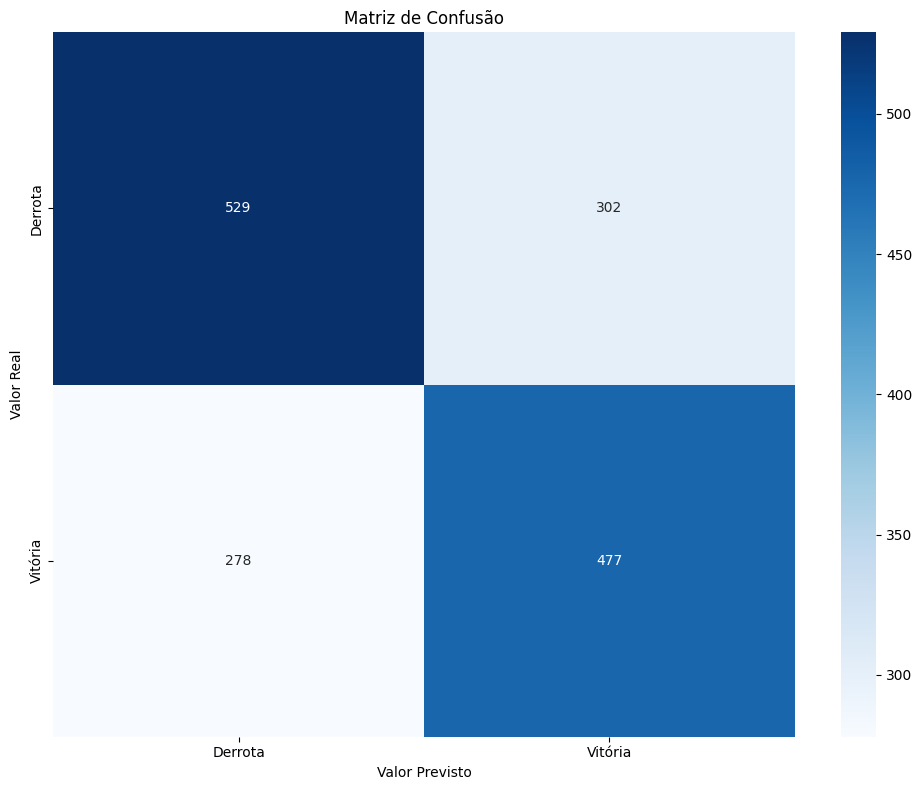

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar a figura e os eixos
plt.figure(figsize=(10,8))

# Criar o heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Adicionar rótulos
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')

# Adicionar rótulos das classes
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, ['Derrota', 'Vitória'])
plt.yticks(tick_marks, ['Derrota', 'Vitória'])

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler  # Importando o RandomUnderSampler
import numpy as np
import pandas as pd

# Remove the columns we don't want to use as features
features = dataprep.drop(['Fight_Result', 'Opponent_ID', 'Athlete_ID_x', 'Athlete_ID_y', 'Fight_Date', 'Delta_Time', 'Last_Round', 'End_Time', 'Victory_Method'], axis=1)

# Handle any remaining non-numeric columns
features = pd.get_dummies(features)

# Handle missing values
features = features.fillna(features.mean())

# Prepare X (features) and y (target)
X = features
y = dataprep['Fight_Result']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomUnderSampler to the training data
under_sampler = RandomUnderSampler(random_state=42)

# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=40)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance)

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.77      0.68       831
           1       0.65      0.47      0.54       755

    accuracy                           0.63      1586
   macro avg       0.63      0.62      0.61      1586
weighted avg       0.63      0.63      0.62      1586


Confusion Matrix:
[[638 193]
 [401 354]]

Top 10 Most Important Features:
                                   feature  importance
0                                   Wins_x    0.033437
652                                 Wins_y    0.027741
1                                 Losses_x    0.026165
4                                 Weight_x    0.024021
3                                 Height_x    0.022373
...                                    ...         ...
1312  Knockdowns_Average_1140-1149_y_False    0.000000
1310  Knockdowns_Average_1120-1129_y_False    0.000000
373           Knockdowns_Average_480-489_x    0.000000
1308  Knockdowns_Average_

## Best model Gradient Boosting

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       831
           1       0.65      0.68      0.66       755

    accuracy                           0.67      1586
   macro avg       0.67      0.67      0.67      1586
weighted avg       0.67      0.67      0.67      1586


Confusion Matrix:
[[550 281]
 [241 514]]

Top 10 Most Important Features:
                                    feature  importance
0                                    Wins_x    0.096621
652                                  Wins_y    0.087421
653                                Losses_y    0.068523
1                                  Losses_x    0.064789
8    Significant_Strikes_Absorbed_Per_Min_x    0.046030
7      Significant_Strikes_Landed_Per_Min_x    0.045465
659    Significant_Strikes_Landed_Per_Min_y    0.039363
660  Significant_Strikes_Absorbed_Per_Min_y    0.030993
661           Takedowns_Average_Per_15min_y    0.025643
9             T

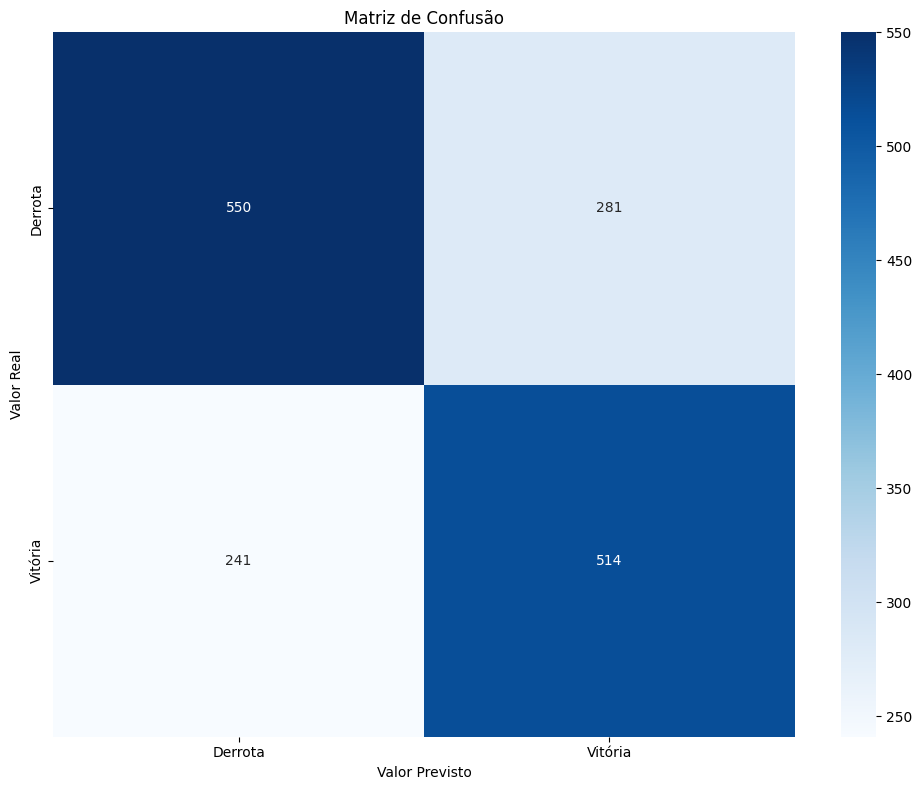

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Remove the columns we don't want to use as features
features = dataprep.drop(['Fight_Result', 'Opponent_ID', 'Fight_Date', 'Delta_Time', 'Last_Round', 'End_Time', 'Victory_Method'], axis=1)

# Handle any remaining non-numeric columns
features = pd.get_dummies(features)

# Handle missing values
features = features.fillna(features.mean())

# Prepare X (features) and y (target)
X = features
y = dataprep['Fight_Result']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomUnderSampler to the training data
under_sampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = under_sampler.fit_resample(X_train, y_train)

# Create and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1)
gb_model.fit(X_train_res, y_train_res)

# Make predictions
y_pred = gb_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': gb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar a figura e os eixos
plt.figure(figsize=(10,8))

# Criar o heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Adicionar rótulos
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')

# Adicionar rótulos das classes
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, ['Derrota', 'Vitória'])
plt.yticks(tick_marks, ['Derrota', 'Vitória'])

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

## Test with xgboost

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       831
           1       0.65      0.69      0.67       755

    accuracy                           0.67      1586
   macro avg       0.68      0.68      0.67      1586
weighted avg       0.68      0.67      0.67      1586


Confusion Matrix:
[[546 285]
 [231 524]]

Top 10 Most Important Features:
                                      feature  importance
5512                Fighting_Style_N/A_y_True    0.025931
652                                    Wins_y    0.023664
0                                      Wins_x    0.021326
224                   Takedowns_Landed_6-10_x    0.019457
653                                  Losses_y    0.019077
11         Significant_Strikes_Landed_50-99_x    0.018441
4520  Significant_Strikes_Landed_50-99_y_True    0.018115
5511               Fighting_Style_N/A_y_False    0.017507
1                                    Losses_x    0.01

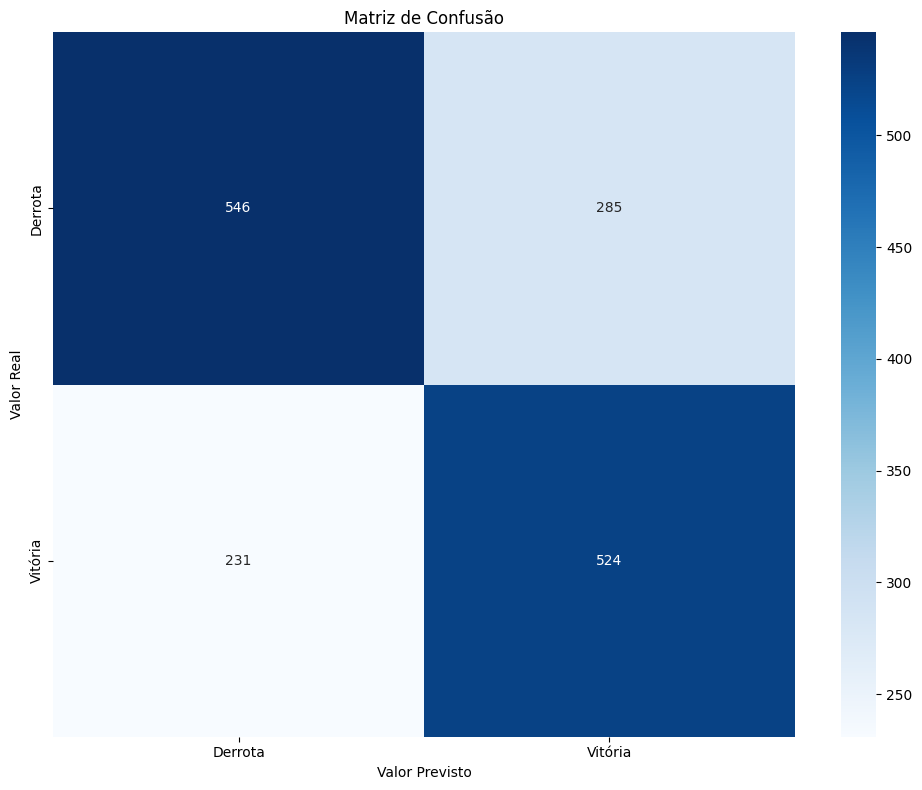

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Remove the columns we don't want to use as features
features = dataprep.drop(['Fight_Result', 'Opponent_ID', 'Fight_Date', 'Delta_Time', 'Last_Round', 'End_Time', 'Victory_Method'], axis=1)

# Handle any remaining non-numeric columns
features = pd.get_dummies(features)

# Handle missing values
features = features.fillna(features.mean())

# Prepare X (features) and y (target)
X = features
y = dataprep['Fight_Result']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomUnderSampler to the training data
under_sampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = under_sampler.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)


# Create and train the Gradient Boosting model
gb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=3, learning_rate=0.1, eval_metric='logloss')
gb_model.fit(X_train_res, y_train_res)

# Make predictions
y_pred = gb_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': gb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criar a figura e os eixos
plt.figure(figsize=(10,8))

# Criar o heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Adicionar rótulos
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')

# Adicionar rótulos das classes
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, ['Derrota', 'Vitória'])
plt.yticks(tick_marks, ['Derrota', 'Vitória'])

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Remove the columns we don't want to use as features
features = dataprep.drop(['Fight_Result', 'Opponent_ID', 'Athlete_ID_x', 'Athlete_ID_y', 'Fight_Date', 'Delta_Time', 'Last_Round', 'End_Time', 'Victory_Method'], axis=1)

# Handle any remaining non-numeric columns
features = pd.get_dummies(features)

# Handle missing values
features = features.fillna(features.mean())

# Prepare X (features) and y (target)
X = features
y = dataprep['Fight_Result']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply RandomUnderSampler to the training data
under_sampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = under_sampler.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árvores
    'max_depth': [3, 5, 7],           # Profundidade máxima das árvores
    'learning_rate': [0.01, 0.1, 0.2], # Taxa de aprendizado
    'min_samples_split': [2, 5, 10],   # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4]      # Número mínimo de amostras em uma folha
}

# Create the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica de avaliação (pode ser 'f1', 'recall', etc.)
    cv=5,                # Número de folds na validação cruzada
    n_jobs=-1,           # Usar todos os núcleos do processador
    verbose=2            # Mostrar logs durante o processo
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_res, y_train_res)

# Print the best parameters and best score
print("\nMelhores hiperparâmetros encontrados:")
print(grid_search.best_params_)
print("\nMelhor score (acurácia) na validação cruzada:")
print(grid_search.best_score_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.8s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.6s


KeyboardInterrupt: 

In [ ]:
from clickhouse_driver import Client
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
import os

load_dotenv()

password = os.getenv('CLICKHOUSE_PASSWORD')

client = Client(
    host='localhost',
    port=9000,
    database='mma_stats_silver',
    user='default',
    password=password
)

fights_columns = [
    "Athlete_ID",
    "Opponent_ID",
    "Fight_Date",
    "Last_Round",
    "End_Time",
    "Victory_Method",
    "Fight_Result",
]

fights_query = "SELECT * FROM ufc_athletes_records"
fights = pd.DataFrame(client.execute(fights_query), columns=fights_columns)

fights["Fight_Date"] = pd.to_datetime(fights["Fight_Date"])
fights["Delta_Time"] = (datetime.now() - fights["Fight_Date"]).dt.days / 365.25
fights["Delta_Time"] = round(fights["Delta_Time"], 0)